<!-- (evaluation)= -->
# WeatherBench 2 Evaluation Quickstart

<a target="_blank" href="https://colab.research.google.com/github/google-research/weatherbench2/blob/main/docs/source/evaluation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this notebook, we will cover the basic functionality of the WeatherBench evaluation framework.

The WeatherBench evaluation framework takes two datasets for forecast and ground truth (called obs, even though reanalysis datasets like ERA5 are not observations), computes and saves the specified metrics.

Here, we will evalute ECMWF's HRES forecast against ERA5.

In [18]:
# Pip might complain about the Pandas version. The notebook should still work as expected.
!pip install git+https://github.com/google-research/weatherbench2.git

  Cloning https://github.com/google-research/weatherbench2.git to /tmp/pip-req-build-x8kceokg
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/weatherbench2.git /tmp/pip-req-build-x8kceokg
  Resolved https://github.com/google-research/weatherbench2.git to commit 75fb2b94cf00bae4c632948d1addfcc86cacc300
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.0
    Uninstalling numpy-2.2.0:
      Successfully uninstalled numpy-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


In [19]:
import apache_beam   # Needs to be imported separately to avoid TypingError
import weatherbench2
import xarray as xr

In [22]:
from google.colab import auth
auth.authenticate_user()

### Specify input datasets

Let's take a look at the datasets. Currently, the WeatherBench pipeline requires all input dataset to be stored as Zarr files.

In [23]:
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_with_poles_conservative.zarr'

Generally, we follow ECMWF's naming conventions for the input files.

* `time` [np.datetime64]: Time at forecast is initialized
* `lead_time` or `prediction_timedelta` [np.timedelta64]: Lead time
* `latitude` [float]: Latitudes from -90 to 90
* `longitude` [float]: Longitudes from 0 to 360
* `level` [hPa]: Pressure levels (optional)

We don't actually need to open the forecast and obs datasets at this point, but we will do so here to see their structure.

In [24]:
xr.open_zarr(forecast_path)

<xarray.Dataset> Size: 172GB
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 256B -87.19 -81.56 ... 87.19
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
  * longitude                 (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 328B 00:...
  * time                      (time) datetime64[ns] 41kB 2016-01-01 ... 2022-...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [25]:
xr.open_zarr(obs_path)

<xarray.Dataset> Size: 81GB
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 256B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 512B ...
  * time                                              (time) datetime64[ns] 736kB ...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 754MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 754MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 754MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 754MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 8kB dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 8kB dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 8kB dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 8kB dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

Some metrics like the ACC also require a climatology file. Refer to the paper for details on how this is computed.

In [26]:
climatology = xr.open_zarr(climatology_path)
climatology

<xarray.Dataset> Size: 1GB
Dimensions:                                      (hour: 4, dayofyear: 366,
                                                  longitude: 64, latitude: 32,
                                                  level: 13)
Coordinates:
  * dayofyear                                    (dayofyear) int64 3kB 1 ... 366
  * hour                                         (hour) int64 32B 0 6 12 18
  * latitude                                     (latitude) float64 256B -90....
  * level                                        (level) int64 104B 50 ... 1000
  * longitude                                    (longitude) float64 512B 0.0...
Data variables: (12/28)
    10m_u_component_of_wind                      (hour, dayofyear, longitude, latitude) float32 12MB dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                      (hour, dayofyear, longitude, latitude) float32 12MB dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_wind_speed                               (hour, dayofyear, longitude, latitude) float32 12MB dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    2m_temperature                               (hour, dayofyear, longitude, latitude) float32 12MB dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    geopotential                                 (hour, dayofyear, level, longitude, latitude) float32 156MB dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure                      (hour, dayofyear, longitude, latitude) float32 12MB dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    ...                                           ...
    total_precipitation_6hr_seeps_dry_fraction   (hour, dayofyear, longitude, latitude) float32 12MB dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    total_precipitation_6hr_seeps_threshold      (hour, dayofyear, longitude, latitude) float32 12MB dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    u_component_of_wind                          (hour, dayofyear, level, longitude, latitude) float32 156MB dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                          (hour, dayofyear, level, longitude, latitude) float32 156MB dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                            (hour, dayofyear, level, longitude, latitude) float32 156MB dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    wind_speed                                   (hour, dayofyear, level, longitude, latitude) float32 156MB dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>

### Set up WeatherBench configuration

Next, we will define a bunch of configuration instances to specify exactly what we want to evaluate.

In [27]:
from weatherbench2 import config

#### Data configuration

The file paths are defined in a Paths config object, alongside an output directory:

In [28]:
paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

In addition, we specify a Selection object that selects the variables and time period to be evaluated.

In [29]:
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-12-31'),
)

Together they make up the Data config:

In [30]:
data_config = config.Data(selection=selection, paths=paths)

#### Evaluation configuration

Next, we can defined which evaluation we want to run. To do so, we can define a dictionary of `config.Eval`s, each of which will be evaluated separately and saved to a different file. Eval instances contain the metrics objects, defined in metrics.py.

Note that for ACC, we additionally need to pass the climatology opened earlier.

In [31]:
from weatherbench2.metrics import MSE, ACC

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology)
      },
  )
}

The evaluation configs also have an option to evaluate particular regions, such as a geographical lat-lon box. These are defined as region objects defined in regions.py. All regions will be evaluated separately and saved as an additional dimension in the dataset. If no region is specified, evaluation will be done globally.

In [32]:
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology)
      },
      regions=regions
  )
}

### Evaluate

Now, we are already done and can run the evaluation. We can do so in memory for smaller datasets or as a Beam pipeline (recommended for anything larger than 64x32 resolution).

In [33]:
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam

In [36]:
data_config

Data(selection=Selection(variables=['geopotential', '2m_temperature'], time_slice=slice('2020-01-01', '2020-12-31', None), levels=[500, 700, 850], lat_slice=slice(None, None, None), lon_slice=slice(None, None, None), aux_variables=None), paths=Paths(forecast='gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr', obs='gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr', output_dir='./', output_file_prefix='', climatology=None), by_init=True, rename_variables=None, pressure_level_suffixes=False)

In [37]:
eval_configs

{'deterministic': Eval(metrics={'mse': MSE(wind_vector_mse=None), 'acc': ACC(climatology=<xarray.Dataset> Size: 1GB
 Dimensions:                                      (hour: 4, dayofyear: 366,
                                                   longitude: 64, latitude: 32,
                                                   level: 13)
 Coordinates:
   * dayofyear                                    (dayofyear) int64 3kB 1 ... 366
   * hour                                         (hour) int64 32B 0 6 12 18
   * latitude                                     (latitude) float64 256B -90....
   * level                                        (level) int64 104B 50 ... 1000
   * longitude                                    (longitude) float64 512B 0.0...
 Data variables: (12/28)
     10m_u_component_of_wind                      (hour, dayofyear, longitude, latitude) float32 12MB dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
     10m_v_component_of_wind                      (hour, dayofyea

In [39]:
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes

/usr/local/lib/python3.10/dist-packages/weatherbench2/evaluation.py:67: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if not min(dataset.dims.values()):
/usr/local/lib/python3.10/dist-packages/weatherbench2/evaluation.py:67: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if not min(dataset.dims.values()):
/usr/local/lib/python3.10/dist-packages/weatherbench2/evaluation.py:67: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, 

ValueError: Data shape (1,) must match shape of object (0,)

For the Beam version, evaluation is split across chunks. The chunk sizes can be specified alongside the Beam runner. For more detail on running Beam in a distributed fashion on the cloud, see [this guide](https://weatherbench2.readthedocs.io/en/latest/beam-in-the-cloud.html).

In [ ]:
# evaluation.evaluate_with_beam(
#     data_config,
#     eval_configs,
#     runner='DirectRunner',
#     input_chunks={'time': 20},
# )

### Results

Results are saved as NetCDF files under the name of the eval config.

In [ ]:
results = xr.open_dataset('./deterministic.nc')
results

<xarray.Dataset>
Dimensions:         (lead_time: 41, region: 3, level: 3, metric: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 00:00:00 ... 10 days 0...
  * region          (region) object 'global' 'tropics' 'extra-tropics'
  * level           (level) int32 500 700 850
  * metric          (metric) object 'acc' 'mse'
Data variables:
    geopotential    (metric, region, lead_time, level) float64 ...
    2m_temperature  (metric, region, lead_time) float64 ...

Note that to compute the RMSE, we follow ECMWF's convention by taking the square root after the time mean. To do this in WB2, first compute the MSE and then take the square root of the saved MSE results.

In [ ]:
results = xr.concat(
    [
    results,
    results.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)

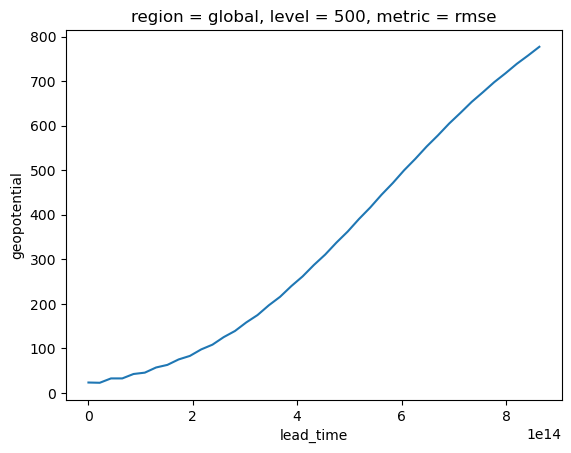

In [ ]:
results['geopotential'].sel(metric='rmse', level=500, region='global').plot();

### Next steps

This quickstart guide shows the basic functionality of the WeatherBench evaluation code but there is more to explore.

For running evaluation from the command line, see [this guide](https://weatherbench2.readthedocs.io/en/latest/command-line-scripts.html). For a complete overview of the entire evaluation workflow, check out the ["submission" guide](https://weatherbench2.readthedocs.io/en/latest/submit.html).